<a href="https://colab.research.google.com/github/aycaaozturk/Image-Based-Detection-of-Nail-Melanoma-Using-Deep-Learning-Techniques/blob/main/ViT_b_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Up

In [ ]:
# Install torchinfo
!pip install torchinfo


Mount Drive , if the data is placed on drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


set up the path for data


In [ ]:
import os

# Define the dataset directory
dataset_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset'

#dataset_dir = '/content/drive/My Drive/binary classification'



Install necessary libraries

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torchinfo import summary


Set Seed for Reproducibility

In [ ]:
def set_seeds(seed=42):      # to produce the same results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds()


Define Helper Functions

In [ ]:
def plot_loss_curves(results):
    epochs = range(1, len(results['train_loss']) + 1)
    plt.figure(figsize=(12,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, results['train_loss'], label='Train Loss')
    plt.plot(epochs, results['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs, results['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

def train(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):   # to create the training loop
    results = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)   # difference between prediction vs true label
            loss.backward()
            optimizer.step()             # updates the parameters

            _, preds = torch.max(outputs, 1)     #  number of correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        # results of an epoch

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        results['train_loss'].append(epoch_loss)
        results['train_acc'].append(epoch_acc.item())

        # Evaluation phase
        model.eval()
        test_running_loss = 0.0
        test_running_corrects = 0
        test_total = 0

        with torch.no_grad():                             # no training, testing only (predicting)
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)


                  # calculates correct predictions and loss

                _, preds = torch.max(outputs, 1)
                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == labels.data)
                test_total += labels.size(0)

        test_epoch_loss = test_running_loss / test_total
        test_epoch_acc = test_running_corrects.double() / test_total
        results['test_loss'].append(test_epoch_loss)
        results['test_acc'].append(test_epoch_acc.item())

        print(f"Epoch: {epoch} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Test Loss: {test_epoch_loss:.4f} | Test Acc: {test_epoch_acc:.4f}")

    return results

def pred_and_plot_image(model, image_path, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    img = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        pred_class = class_names[preds.item()]

    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()


In [ ]:
# Define paths with the correct directory structure
train_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/train'
test_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/test'


#train_dir = '/content/drive/My Drive/binary classification/train'
#test_dir = '/content/drive/My Drive/binary classification/test'


Prepare Data Loaders

In [ ]:
# 6. Prepare Data Loaders

# Define paths
train_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/train'
test_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/test'

#train_dir = '/content/drive/My Drive/binary classification/train'
#test_dir = '/content/drive/My Drive/binary classification/test'

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Get pretrained ViT transforms
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT     # loads the pretrained model weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Create DataLoaders
# data preprocessing

def create_dataloaders(train_dir, test_dir, transform, batch_size=32, num_workers=2):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    class_names = train_data.classes

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader, class_names

train_loader, test_loader, class_names = create_dataloaders(   # creates the train and test dataset, applies necessary transforms
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32,   #CHANGE BATCH SIZE HERE  FIRST VALUE:16
    num_workers=2
)

print(f"Classes: {class_names}")   # which classes the model recognizes


Using device: cuda
Classes: ['healthy', 'melanoma', 'other']


Load and Modify the Pretrained ViT Model

In [ ]:
# Load pretrained ViT model
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)   # loads the pretrained model

# Freeze all parameters
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Replace the classifier head                  ->>> alters (customizes) the classifier head

num_features = pretrained_vit.heads.head.in_features
pretrained_vit.heads.head = nn.Linear(num_features, len(class_names)).to(device)

# Print model summary
summary(pretrained_vit, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 186MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Train the Model

In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(pretrained_vit.heads.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()



# Train the model
epochs = 20

results = train(
    model=pretrained_vit,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device,


)


Epoch: 1 | Train Loss: 0.4323 | Train Acc: 0.8449 | Test Loss: 0.2795 | Test Acc: 0.9101
Epoch: 2 | Train Loss: 0.2322 | Train Acc: 0.9287 | Test Loss: 0.2096 | Test Acc: 0.9373
Epoch: 3 | Train Loss: 0.1800 | Train Acc: 0.9480 | Test Loss: 0.1694 | Test Acc: 0.9456
Epoch: 4 | Train Loss: 0.1526 | Train Acc: 0.9554 | Test Loss: 0.1515 | Test Acc: 0.9574
Epoch: 5 | Train Loss: 0.1331 | Train Acc: 0.9601 | Test Loss: 0.1359 | Test Acc: 0.9621
Epoch: 6 | Train Loss: 0.1202 | Train Acc: 0.9652 | Test Loss: 0.1289 | Test Acc: 0.9621
Epoch: 7 | Train Loss: 0.1069 | Train Acc: 0.9706 | Test Loss: 0.1207 | Test Acc: 0.9669
Epoch: 8 | Train Loss: 0.0976 | Train Acc: 0.9723 | Test Loss: 0.1163 | Test Acc: 0.9728
Epoch: 9 | Train Loss: 0.0899 | Train Acc: 0.9743 | Test Loss: 0.1125 | Test Acc: 0.9692
Epoch: 10 | Train Loss: 0.0840 | Train Acc: 0.9774 | Test Loss: 0.1046 | Test Acc: 0.9704
Epoch: 11 | Train Loss: 0.0775 | Train Acc: 0.9794 | Test Loss: 0.1033 | Test Acc: 0.9716
Epoch: 12 | Train L

Save the model

In [ ]:
torch.save(pretrained_vit,"/content/drive/My Drive/models best/vision transformer/nail_vit_full_model.pth")


Plot Loss Curves

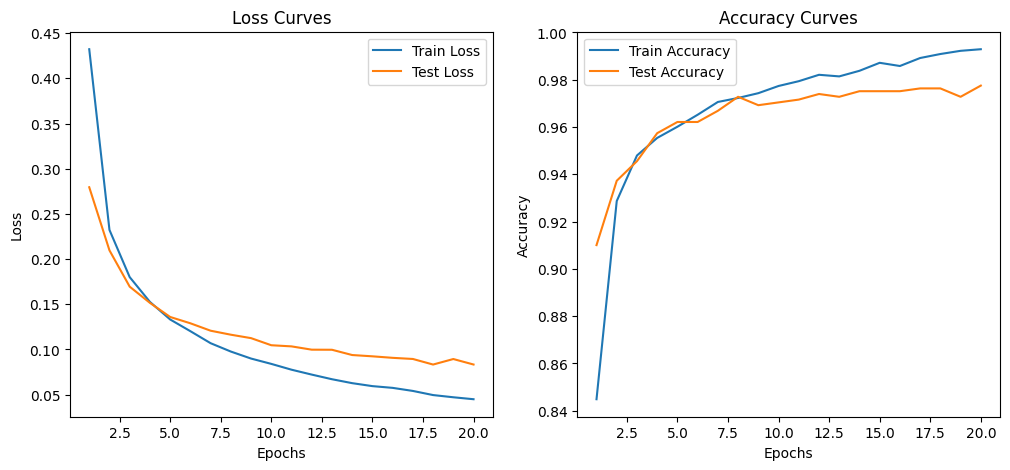

In [ ]:
plot_loss_curves(results)


missclassified (conf matrix)

In [ ]:
import os
import torch
from torchvision.utils import save_image

def save_misclassified_images(
    model,
    loader,
    device,
    class_names,
    out_dir="misclassified_VIT",
    denormalize=False,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
):
    """
    Saves all misclassified images from a loader to `out_dir`.

    Filenames include global index, true label, and predicted label.
    """

    os.makedirs(out_dir, exist_ok=True)

    model.eval()
    counter = 0
    global_idx = 0

    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            preds = logits.argmax(dim=1)

            for i in range(len(imgs)):
                true_lbl = labels[i].item()
                pred_lbl = preds[i].item()

                if pred_lbl != true_lbl:
                    true_name = class_names[true_lbl]
                    pred_name = class_names[pred_lbl]

                    # Filename format
                    filename = (
                        f"{global_idx:05d}"
                        f"_true-{true_name}"
                        f"_pred-{pred_name}.png"
                    )

                    path = os.path.join(out_dir, filename)

                    img_to_save = imgs[i].detach().cpu()

                    # optional: denormalize
                    if denormalize:
                        img_to_save = img_to_save * std + mean
                        img_to_save = img_to_save.clamp(0,1)

                    save_image(img_to_save, path)
                    counter += 1

                global_idx += 1

    print(f"Saved {counter} misclassified images → {out_dir}/")



save_misclassified_images(pretrained_vit, test_loader, device, class_names,
                          out_dir="misclassified_images",
                          denormalize=True)

Saved 19 misclassified images → misclassified_images/


Accuracy        : 0.9775
Balanced Acc    : 0.9712

Classification report:
              precision    recall  f1-score   support

     healthy       0.98      0.99      0.98       363
    melanoma       0.99      0.95      0.97       146
       other       0.97      0.98      0.98       336

    accuracy                           0.98       845
   macro avg       0.98      0.97      0.97       845
weighted avg       0.98      0.98      0.98       845



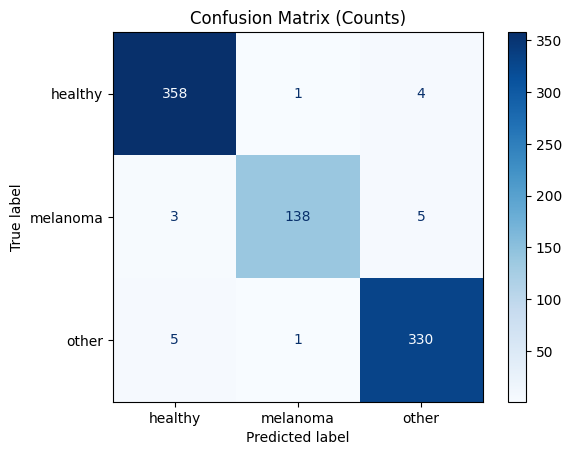

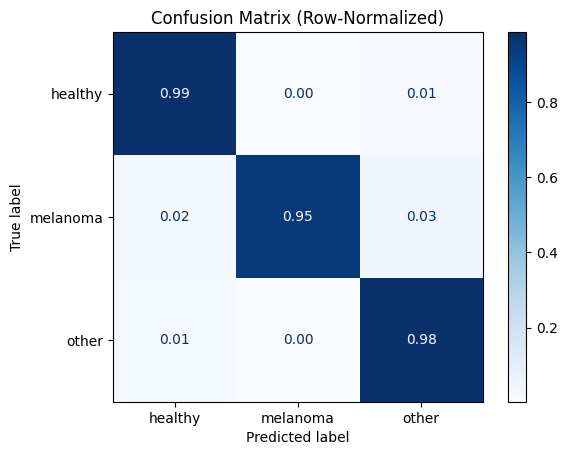


=== Curves with positive class 'healthy' ===


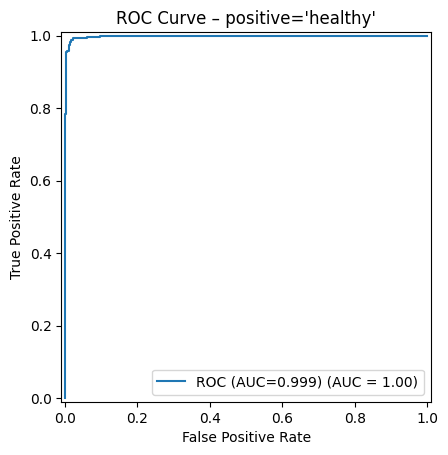

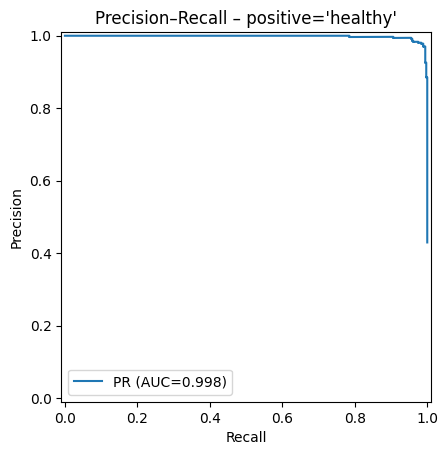


=== Curves with positive class 'melanoma' ===


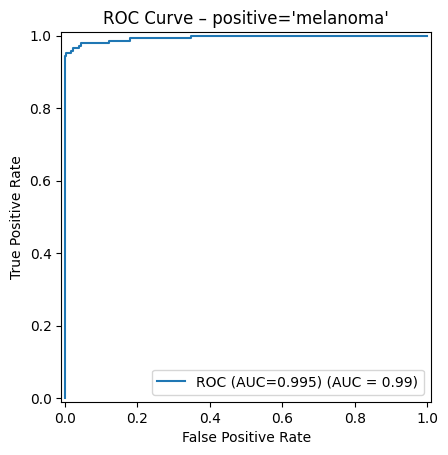

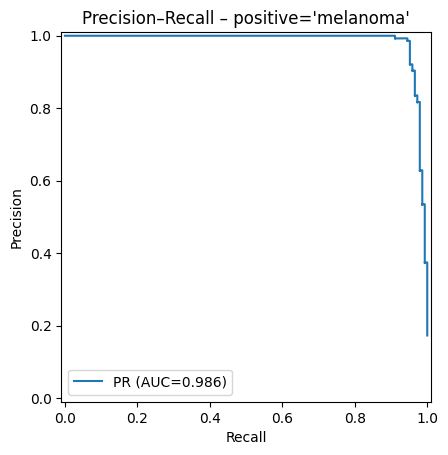


=== Curves with positive class 'other' ===


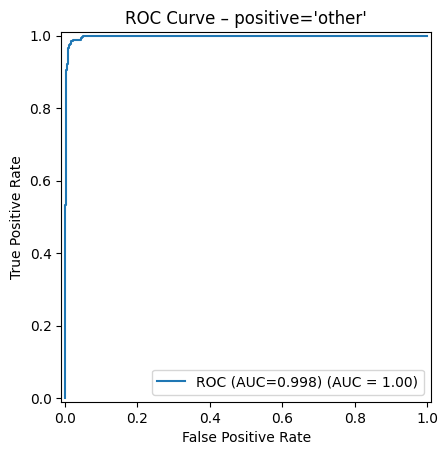

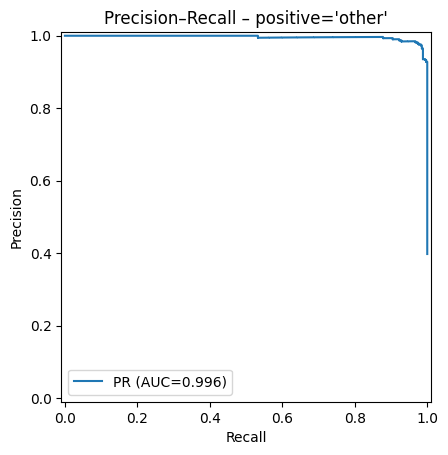

In [ ]:
# ==== Metrics & Visualizations ====
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve, RocCurveDisplay,
    PrecisionRecallDisplay, accuracy_score, balanced_accuracy_score
)
import torch.nn.functional as F

@torch.no_grad()
def collect_predictions(model, loader, device):
    model.eval()
    all_logits = []
    all_targets = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())
    all_logits = torch.cat(all_logits, dim=0)          # [N, C]
    all_targets = torch.cat(all_targets, dim=0)        # [N]
    return all_logits, all_targets

logits, targets = collect_predictions(pretrained_vit, test_loader, device)
num_classes = logits.shape[1]

# Predicted class indices
preds = logits.argmax(dim=1)

# Basic scores
acc = accuracy_score(targets, preds)
bacc = balanced_accuracy_score(targets, preds)
print(f"Accuracy        : {acc:.4f}")
print(f"Balanced Acc    : {bacc:.4f}")

# Classification report (precision/recall/F1 per class + macro/micro/weighted)
print("\nClassification report:")
print(classification_report(targets, preds, target_names=class_names))

# ---- Confusion Matrix (counts + normalized) ----
cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Counts)')
plt.show()

disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm.astype(float) / cm.sum(axis=1, keepdims=True),
    display_labels=class_names
)
disp_norm.plot(cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix (Row-Normalized)')
plt.show()

# ---- ROC & PR curves ----
# For multi-class we do one-vs-rest curves; for binary we show the positive class curve.
probs = F.softmax(logits, dim=1).numpy()  # [N, C]
y_true = targets.numpy()

def plot_binary_curves(pos_class_idx):
    y_score = probs[:, pos_class_idx]
    y_bin = (y_true == pos_class_idx).astype(int)

    fpr, tpr, _ = roc_curve(y_bin, y_score)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                    estimator_name=f"ROC (AUC={roc_auc:.3f})").plot()
    plt.title(f"ROC Curve – positive='{class_names[pos_class_idx]}'")
    plt.show()

    prec, rec, _ = precision_recall_curve(y_bin, y_score)
    pr_auc = auc(rec, prec)
    PrecisionRecallDisplay(precision=prec, recall=rec,
                           estimator_name=f"PR (AUC={pr_auc:.3f})").plot()
    plt.title(f"Precision–Recall – positive='{class_names[pos_class_idx]}'")
    plt.show()

if num_classes == 2:
    # choose class index 1 as "positive" by convention; adjust if needed
    pos_idx = 1
    print(f"Assuming positive class is: '{class_names[pos_idx]}'")
    plot_binary_curves(pos_idx)
else:
    # one-vs-rest for each class
    for c in range(num_classes):
        print(f"\n=== Curves with positive class '{class_names[c]}' ===")
        plot_binary_curves(c)

# ---- Optional: threshold tuning for imbalanced binary data ----
# If your classes are imbalanced and you want to adjust the decision threshold,
# you can pick the threshold that maximizes Youden's J (TPR - FPR) on the ROC curve.
if num_classes == 2:
    y_score = probs[:, pos_idx]
    y_bin = (y_true == pos_idx).astype(int)
    fpr, tpr, thr = roc_curve(y_bin, y_score)
    j = tpr - fpr
    best_idx = j.argmax()
    best_thr = thr[best_idx]
    print(f"\nSuggested threshold by Youden's J: {best_thr:.3f}")

    tuned_preds = (y_score >= best_thr).astype(int)
    print("\nReport @ tuned threshold:")
    print(classification_report(y_bin, tuned_preds, target_names=[f"not {class_names[pos_idx]}", class_names[pos_idx]]))

    cm_tuned = confusion_matrix(y_bin, tuned_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm_tuned,
                           display_labels=[f"not {class_names[pos_idx]}", class_names[pos_idx]]).plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix @ threshold={best_thr:.3f}')
    plt.show()


Make a prediction with custom Image

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from google.colab import files

# Assuming you've already defined and loaded your model
pretrained_vit.eval()  # Set model to evaluation mode

# Define image transformations
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop(224),      # Crop to 224x224
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Upload images
uploaded = files.upload()

# Print the uploaded filenames
print("Uploaded files:")
for filename in uploaded.keys():
    print(filename)

# Use the uploaded file(s) for prediction
for image_path in uploaded.keys():
    print(f"Processing {image_path}...")
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    image = pretrained_vit_transforms(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = pretrained_vit(image)  # Get model outputs
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    # Print the prediction
    print(f"Predicted class for {image_path}: {class_names[predicted.item()]}")


Saving NAILwue_1 _(1)_obj1.jpg to NAILwue_1 _(1)_obj1 (1).jpg
Uploaded files:
NAILwue_1 _(1)_obj1 (1).jpg
Processing NAILwue_1 _(1)_obj1 (1).jpg...


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Save the model

In [ ]:
# Save the entire model
torch.save(pretrained_vit.state_dict(), 'pretrained_vit_model.pth')


Collecting the traininig results, insure it will run the code again. # Not Working, Needs troubleshooting

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

# Assuming `pretrained_vit` is your model and `train_loader`, `test_loader` are your data loaders

# Define optimizer and loss function
optimizer = optim.Adam(pretrained_vit.heads.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Define the number of epochs for training
num_epochs = 10

# Initialize a dictionary to store training results
pretrained_vit_results = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

# Training loop
for epoch in range(num_epochs):
    pretrained_vit.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # Training step
    for images, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = pretrained_vit(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss += loss.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        train_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Total examples

    # Calculate training metrics
    train_loss /= total_train
    train_accuracy = train_correct / total_train

    # Validation step
    pretrained_vit.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            outputs = pretrained_vit(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation metrics
    val_loss /= total_val
    val_accuracy = val_correct / total_val

    # Save the results for this epoch
    pretrained_vit_results['epoch'].append(epoch + 1)  # Store epoch number (1-indexed)
    pretrained_vit_results['train_loss'].append(train_loss)
    pretrained_vit_results['train_accuracy'].append(train_accuracy)
    pretrained_vit_results['val_loss'].append(val_loss)
    pretrained_vit_results['val_accuracy'].append(val_accuracy)

    # Print results for the current epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Loss: {val_loss:.4f} | Test Acc: {val_accuracy:.4f}")

# After training, convert to DataFrame and save
results_df = pd.DataFrame(pretrained_vit_results)
results_df.to_csv('training_results.csv', index=False)

print("Training results saved to 'training_results.csv'.")


AttributeError: 'EfficientNet' object has no attribute 'heads'

 Collecting Prediction Results

In [ ]:
# Initialize a dictionary to store prediction results
pretrained_vit_prediction_results = {
    'image_path': [],
    'predicted_class': []
}

# Use the uploaded file(s) for prediction
for image_path in uploaded.keys():
    print(f"Processing {image_path}...")
    image = Image.open(image_path).convert("RGB")
    image = pretrained_vit_transforms(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        outputs = pretrained_vit(image)
        _, predicted = torch.max(outputs, 1)

    # Save the prediction result
    pretrained_vit_prediction_results['image_path'].append(image_path)
    pretrained_vit_prediction_results['predicted_class'].append(class_names[predicted.item()])

# After prediction, convert to DataFrame and save
prediction_results_df = pd.DataFrame(pretrained_vit_prediction_results)
prediction_results_df.to_csv('prediction_results.csv', index=False)


Processing test_image2.jpg...


In [ ]:
# Downloading files from google colab
from google.colab import files

files.download('pretrained_vit_model.pth')
files.download('training_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>